<a href="https://colab.research.google.com/github/Sri190/Deep-Learning-Projects--Youtube/blob/main/DL_Project%3D21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

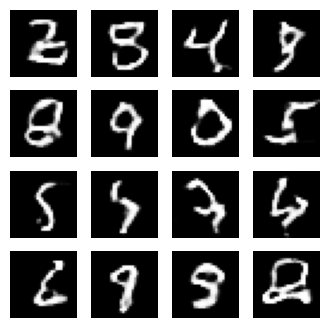

In [1]:
# Import Libraries
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import tensorflow as tf

# -----------------------------------------------
# Load and Preprocess MNIST
# -----------------------------------------------
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1,1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# -----------------------------------------------
# Generator Model
# -----------------------------------------------
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# -----------------------------------------------
# Discriminator Model
# -----------------------------------------------
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

# -----------------------------------------------
# Loss Functions
# -----------------------------------------------
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# -----------------------------------------------
# Checkpointing
# -----------------------------------------------
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

# -----------------------------------------------
# Training Setup
# -----------------------------------------------
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# Seed for fixed images
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# -----------------------------------------------
# Generate and Save Images
# -----------------------------------------------
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :, 0] * 127.5) + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
    plt.show()

# -----------------------------------------------
# Training Loop
# -----------------------------------------------
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Display images
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save checkpoint every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print("Time for epoch {} is {:.2f} sec".format(epoch + 1, time.time() - start))

    # Final image
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

# -----------------------------------------------
# Run Training
# -----------------------------------------------
train(train_dataset, EPOCHS)